In this notebook, I will apply adaptive learning rate algorithms to linear regression problem.  
Adaptive learning rate helps the learning algorithm if there are some dense features and others are sparse (when the the gradient vector will be unbalanced); it will give higher learning rate to the sparse features (the ones with small derivative) and small learning rate to the dense features (the ones with high derivative) and therefore they are called adaptive.

## Importing required libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.sparse

%matplotlib inline
np.random.seed(44)

## Visualization functions:

### Visualizing the best fit surface:

Visualizes the best fit surface using 3 points on it.

In [2]:
def visualize_best_fit_surface(ax, h_start, h_end, v_start, v_end, x_points, y_points, theta):
    non_zero = np.where(x_points[:, 1] != 0)[0][0]
    points = np.hstack([x_points[non_zero: non_zero+3], x_points[non_zero: non_zero+3] @ theta])
    
    p0, p1, p2 = points
    x0, y0, z0 = p0
    x1, y1, z1 = p1
    x2, y2, z2 = p2

    ux, uy, uz = u = [x1-x0, y1-y0, z1-z0]
    vx, vy, vz = v = [x2-x0, y2-y0, z2-z0]

    u_cross_v = [uy*vz-uz*vy, uz*vx-ux*vz, ux*vy-uy*vx]

    point  = np.array(p0)
    normal = np.array(u_cross_v)
    d = -point.dot(normal)
    xx, yy = np.meshgrid(range(h_start, h_end), range(v_start, v_end))
    z = (-normal[0] * xx - normal[1] * yy - d) * 1. / normal[2]

    # plot the surface
    ax.plot_surface(xx, yy, z, color='r', alpha=0.1)
    ax.scatter(x_points[:, 0], x_points[:, 1], y_points)
    ax.set_xlim3d(x1_points.min(), x1_points.max())
    ax.set_ylim3d(x2_points.min(), x2_points.max())
    ax.set_zlim3d(y_points.min(), y_points.max())
    plt.show();

### Visualizing the cost function:

Plot the cost function of Linear regression, the parameters updates and the countour plot.

In [3]:
def visualize_cost(ax1, ax2, h_start, h_end, v_start, v_end, x_points, y_points, thetas_hist, costs, optim_theta,
                   algorithm_name, parameters_names, stochastic=False):
    n = 50
    t0 = np.linspace(h_start, h_end, n, endpoint=True)
    t1 = np.linspace(v_start, v_end, n, endpoint=True)
    X, Y = np.meshgrid(t0, t1)
    Z = np.zeros((n, n))

    h = lambda theta_0, theta_1, x: theta_0 * x[:, 0] + theta_1 * x[:, 1]
    J = lambda theta_0, theta_1, x, y: (1/(2*x.shape[0])) * (h(theta_0, theta_1, x).reshape(-1, 1) - y).T \
        @ (h(theta_0, theta_1, x).reshape(-1, 1) - y)

    for i in range(n):
        for j in range(n):
            Z[i, j] = J(X[i, j], Y[i, j], x_points, y_points)
    
    if stochastic:
        costs = []
        for i in range(len(thetas_hist)):
            costs.append((J(thetas_hist[i, 0], thetas_hist[i, 1], x_points, y_points)).item())

    ax1.plot_surface(X, Y, Z, alpha=0.5)
    ax1.plot(thetas_hist[:, 0], thetas_hist[:, 1], costs, '-o', alpha=1)
    ax1.scatter(thetas_hist[-1][0], thetas_hist[-1][1], 
                J(thetas_hist[-1][0], thetas_hist[-1][1], x_points, y_points), c='blue', label=algorithm_name+' theta')
    ax1.scatter(optim_theta[0], optim_theta[1], J(optim_theta[0], optim_theta[1], x_points, y_points), c='red', label="Optimal theta")
    ax1.set_xlabel(parameters_names[0])
    ax1.set_ylabel(parameters_names[1])
    ax1.set_zlabel('J')

    ax2.contour(X, Y, Z, levels=20, zorder=0)
    ax2.plot(thetas_hist[:, 0], thetas_hist[:, 1], '-o', c='orange', zorder=0)
    ax2.scatter(thetas_hist[-1][0], thetas_hist[-1][1], c='blue', label=algorithm_name+' theta', zorder=2)
    ax2.scatter(optim_theta[0, 0], optim_theta[1, 0], c='red', label="Optimal theta", zorder=1)
    ax2.set_xlabel(parameters_names[0])
    ax2.set_ylabel(parameters_names[1])
    ax2.legend()

## Data points: 

Here we have 2 features: $x_1, x_2$ both have similar range $[0, 10]$ but $x_2$ is sparse.

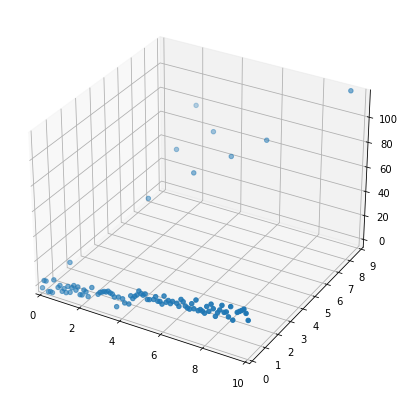

In [4]:
x1_points = np.linspace(0, 10, 100).reshape(-1, 1)
x2_points = (scipy.sparse.rand(100, 1, 0.1, random_state=44).toarray()*10).astype('int8')
noise = np.random.normal(loc=0, scale=np.sqrt(9), size=(100, 1))
y_points = 3 * x1_points + 10 * x2_points + noise

x_points = np.hstack([x1_points.reshape(-1, 1), x2_points.reshape(-1, 1)])
y_points = y_points.reshape((-1, 1))

plt.figure(figsize = (10, 7))
plt3d = plt.axes(projection='3d')
plt3d.scatter(x_points[:, 0], x_points[:, 1], y_points)
plt3d.set_xlim3d(x1_points.min(), x1_points.max())
plt3d.set_ylim3d(x2_points.min(), x2_points.max())
plt3d.set_zlim3d(y_points.min(), y_points.max())
plt.show();

## Analytical Solution: 

Optimal theta 1:  2.967927464351707
Optimal theta 2:  9.839333155888966


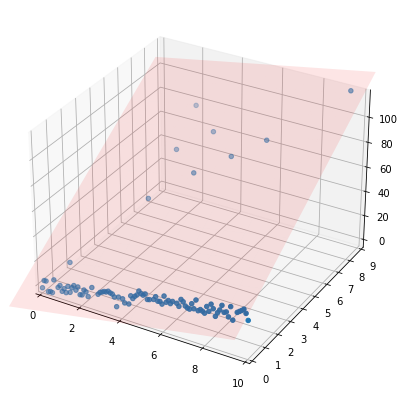

In [5]:
x_points_analytic = x_points.copy()
optimal_theta = (np.linalg.inv(x_points_analytic.T @ x_points_analytic)) @ x_points_analytic.T @ y_points
print("Optimal theta 1: ", optimal_theta[0, 0])
print("Optimal theta 2: ", optimal_theta[1, 0])

plt.figure(figsize = (10, 7))
ax = plt.axes(projection='3d')
visualize_best_fit_surface(ax, -1, 11, -1, 11, x_points, y_points, optimal_theta)

In [6]:
def GradientDescent(X, y, fit_intercept=True, lr=0.001, epochs=10):
    m, n = X.shape

    if fit_intercept:
        X = np.hstack([np.ones((m, 1)), X])
        n += 1
    thetas = np.zeros((n, 1))
    thetas_hist = []
    costs = []
    
    for i in range(epochs):
        thetas_hist.append(thetas)
        y_predicted = X @ thetas
        e = y_predicted - y
        cost = 1/(2*m) * e.T @ e
        costs.append(cost.item())
        grad_theta = 1/m * X.T @ e
        thetas = thetas - lr * grad_theta
    return thetas_hist, costs

With the usual GD algorithm, dense features will converge in small number of iterations, while sparse features will have a very small partial derivative so it will take much more features untill convergence. So the overall process will need a large number of iterations.

GD theta 1:  2.96795047499542
GD theta 2:  9.839065243562686


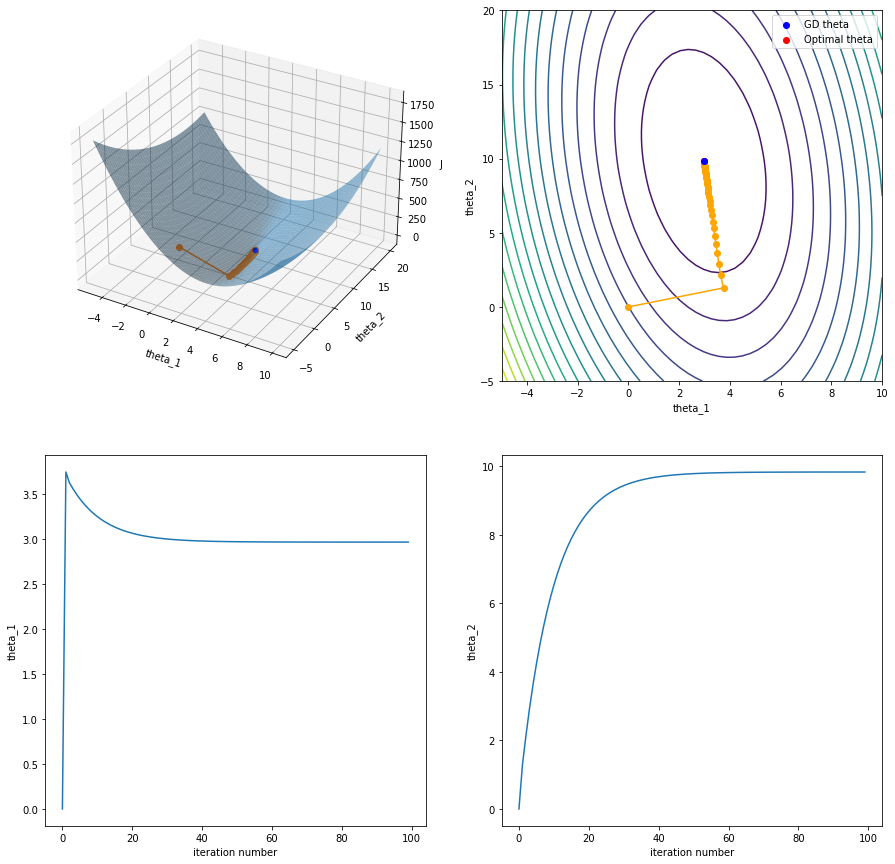

In [7]:
thetas_hist, costs = GradientDescent(x_points, y_points, fit_intercept=False, lr=0.03, epochs=100)
thetas_hist = np.asarray(thetas_hist).reshape((-1, 2))
print("GD theta 1: ", thetas_hist[-1][0])
print("GD theta 2: ", thetas_hist[-1][1])
    
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222)
visualize_cost(ax1, ax2, -5, 10, -5, 20, x_points, y_points, thetas_hist, costs, optimal_theta, 'GD', ['theta_1', 'theta_2'])

ax3 = fig.add_subplot(223)
ax3.set_xlabel('iteration number')
ax3.set_ylabel('theta_1')
ax3.plot(range(thetas_hist.shape[0]), thetas_hist[:, 0])


ax4 = fig.add_subplot(224)
ax4.set_xlabel('iteration number')
ax4.set_ylabel('theta_2')
ax4.plot(range(thetas_hist.shape[0]), thetas_hist[:, 1])
plt.show()

As we can see, $\theta_1$ associated with the dense feature reached its value in nearly 20 iterations, while $\theta_2$ associated with the sparse feature will take only small steps and will reach its value in nearly 50 iterations or more.

## `1)` AdaGrad:

AdaGrad algorithm uses an adaptive learning rate that gives a higher learning rate to the parameters associated with sparse features so they can reach the optimal value faster on the price of giving lower learning rate to the parameters associated with dense features.  
It does that by keeping track of the magnitudes of all the previous gradients and dividing the learning rate for each feature by the corresponding component of that sum.

$$Input: X$$
$$Parameters: \theta$$  
$$Hypothesis: h_{\theta}(X) = X \theta$$  
$$Cost function: J(\theta) = \frac{1}{2m}(h_\theta(x^{(i)}) - y^{(i)})^T (h_\theta(x^{(i)}) - y^{(i)})$$  
$$Gradient: \nabla_\theta J(\theta) = \frac{1}{m} X^T (h_\theta(x^{(i)}) - y^{(i)})$$
$$Goal: \theta^* = min_\theta  J(\theta) $$  
$$Update\space step: s_t = \beta s_{t-1} + (\nabla J(\theta))^2$$
$$\theta_{t+1} = \theta_t - \frac{\alpha}{\sqrt{s_t} + \epsilon}*\nabla J(\theta)$$

In [8]:
def AdaGrad(X, y, fit_intercept=True, lr=0.001, beta=0.99, epochs=10):
    m, n = X.shape
    X = X.copy()
    if fit_intercept:
        X = np.hstack([np.ones((m, 1)), X])
        n += 1
    eps = 1e-13
    thetas = np.zeros((n, 1))
    s = 0
    thetas_hist = []
    costs = []
    
    for i in range(epochs):
        thetas_hist.append(thetas)
        y_predicted = X @ thetas
        e = y_predicted - y
        cost = 1/(2*m) * e.T @ e
        costs.append(cost.item())
        grad = 1/m * X.T @ e
        s = beta * s + np.power(grad, 2)
        thetas = thetas - lr / (np.sqrt(s) + eps) * grad
    return thetas_hist, costs

AdaGrad theta 1:  3.0627981725145945
AdaGrad theta 2:  8.784606538083935


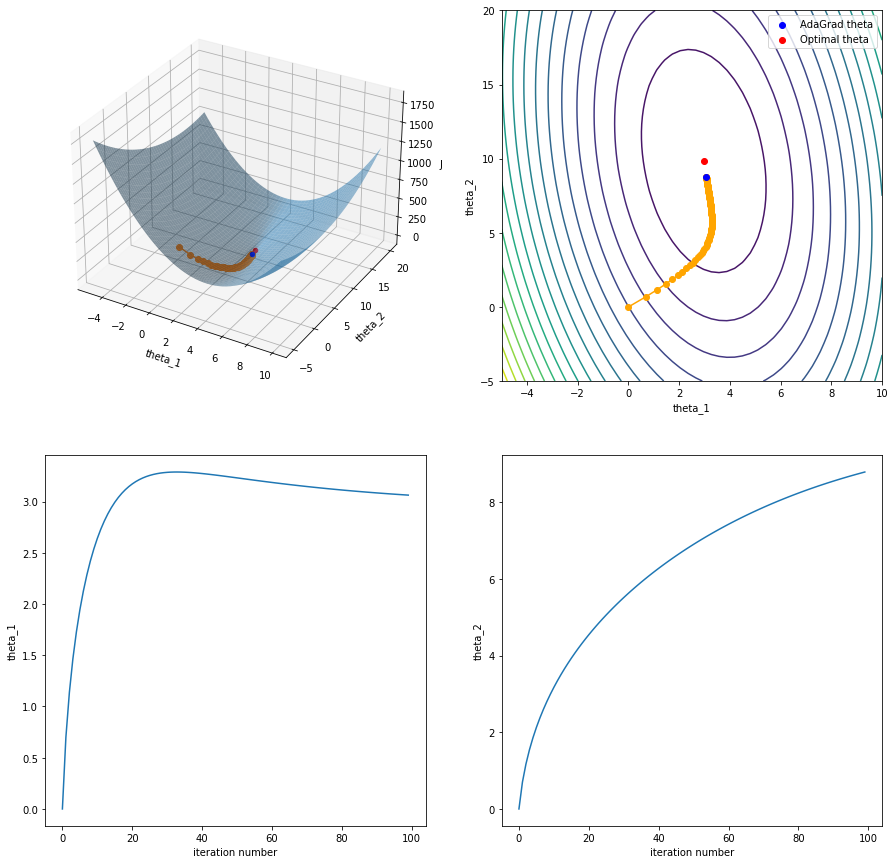

In [9]:
thetas_hist, costs = AdaGrad(x_points, y_points, fit_intercept=False, lr=0.7, beta=0.99, epochs=100)
thetas_hist = np.asarray(thetas_hist).reshape((-1, 2))
print("AdaGrad theta 1: ", thetas_hist[-1][0])
print("AdaGrad theta 2: ", thetas_hist[-1][1])
  
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222)
visualize_cost(ax1, ax2, -5, 10, -5, 20, x_points, y_points, thetas_hist, costs, optimal_theta, 'AdaGrad', ['theta_1', 'theta_2'])

ax3 = fig.add_subplot(223)
ax3.set_xlabel('iteration number')
ax3.set_ylabel('theta_1')
ax3.plot(range(thetas_hist.shape[0]), thetas_hist[:, 0])


ax4 = fig.add_subplot(224)
ax4.set_xlabel('iteration number')
ax4.set_ylabel('theta_2')
ax4.plot(range(thetas_hist.shape[0]), thetas_hist[:, 1])
plt.show()

As expected, the problem with AdaGrad is killing the learning rate, as the sum accumelates the squares of the gradients, it will eventually reach a very high value and when we divide the learning rate by that large value, it will give a small number (nearly zero).  
So, the algorithm might get close to the optimal parameters values but it will never reach it.

### Mini-batch AdaGrad:

In [10]:
def MiniBatchAdaGrad(X, y, fit_intercept=True, lr=0.001, beta=0.99, epochs=10, batch_size = 64, shuffle=True):
    m, n = X.shape
    
    X = X.copy()
    if fit_intercept:
        X = np.hstack([np.ones((m, 1)), X])
        n += 1
        
    if shuffle:
        idx = np.arange(m)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]
        
    n_batches = m // batch_size
    eps = 1e-13
    thetas = np.zeros((n, 1))
    s = 0
    thetas_hist = []
    costs = []
    
    for i in range(epochs):
        for b in range(n_batches):
            thetas_hist.append(thetas)
            X_batch = X[b * batch_size: (b+1) * batch_size]
            y_batch = y[b * batch_size: (b+1) * batch_size]
            y_predicted = X_batch @ thetas
            e_batch = y_predicted - y_batch
            cost = 1/(2*batch_size) * e_batch.T @ e_batch
            costs.append(cost.item())
            grad = 1/batch_size * X_batch.T @ e_batch
            s = beta * s + np.power(grad, 2)
            thetas = thetas - lr / (np.sqrt(s) + eps) * grad
    return thetas_hist, costs

Mini-batch AdaGrad theta 1:  3.089186845089947
Mini-batch AdaGrad theta 2:  8.449826622681254


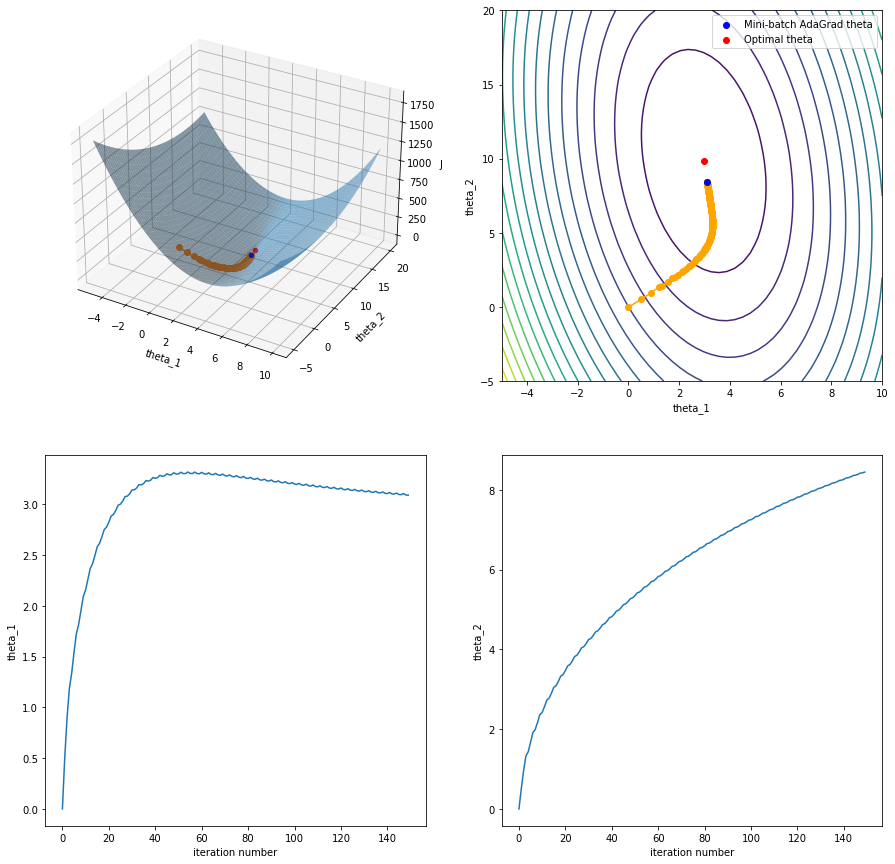

In [11]:
thetas_hist, costs = MiniBatchAdaGrad(x_points, y_points, fit_intercept=False,lr=0.5, beta=0.99, epochs=50, batch_size=32, shuffle=True)
thetas_hist = np.asarray(thetas_hist).reshape((-1, 2))
print("Mini-batch AdaGrad theta 1: ", thetas_hist[-1][0])
print("Mini-batch AdaGrad theta 2: ", thetas_hist[-1][1])

fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222)
visualize_cost(ax1, ax2, -5, 10, -5, 20, x_points, y_points, thetas_hist, costs, optimal_theta
               , 'Mini-batch AdaGrad', ['theta_1', 'theta_2'], stochastic=True)


ax3 = fig.add_subplot(223)
ax3.set_xlabel('iteration number')
ax3.set_ylabel('theta_1')
ax3.plot(range(thetas_hist.shape[0]), thetas_hist[:, 0])


ax4 = fig.add_subplot(224)
ax4.set_xlabel('iteration number')
ax4.set_ylabel('theta_2')
ax4.plot(range(thetas_hist.shape[0]), thetas_hist[:, 1])
plt.show()

## `2)` RMSProp:

RMSProp prevents the rapid growth in $s_t$ by accumulating the previous gradients in some portion(weight) rateher than accumulating squared gradients from the beginning.
RMSProp algorithm tries to solve the problem of killing the gradient.  
It does so by keeping an exponentially weighted moving average of the square of the past gradient rather than keeping their sum as in Adagrad, this gives a higher weight to the most recent gradient the weight of the previous gradients decays exponentially.  
In AdaGrad, if a parameter had high previous gradients but it began to get closer to optimal value, both its learning rate and its gradient component will become very small and its learning rate will be zero and it will never converge. But with RSMProp, the previous history will have much smaller effect and since most recent gradients components are very small, the coressponding learning rate will become much bigger and it will help it converge.

$$Input: X$$
$$Parameters: \theta$$  
$$Hypothesis: h_{\theta}(X) = X \theta$$  
$$Cost function: J(\theta) = \frac{1}{2m}(h_\theta(x^{(i)}) - y^{(i)})^T (h_\theta(x^{(i)}) - y^{(i)})$$  
$$Gradient: \nabla_\theta J(\theta) = \frac{1}{m} X^T (h_\theta(x^{(i)}) - y^{(i)})$$
$$Goal: \theta^* = min_\theta  J(\theta) $$  
$$Update\space step: s_t = \beta s_{t-1} + (1-\beta) (\nabla J(\theta))^2$$
$$\theta_{t+1} = \theta_t - \frac{\alpha}{\sqrt{s_t} + \epsilon}*\nabla J(\theta)$$

In [12]:
def RMSProp(X, y, fit_intercept=True, lr=0.001, beta=0.99, epochs=10):
    m, n = X.shape

    if fit_intercept:
        X = np.hstack([np.ones((m, 1)), X])
        n += 1
    
    eps = 1e-13
    thetas = np.zeros((n, 1))
    s = 0
    thetas_hist = []
    costs = []
    
    for i in range(epochs):
        thetas_hist.append(thetas)
        y_predicted = X @ thetas
        e = y_predicted - y
        cost = 1/(2*m) * e.T @ e
        costs.append(cost.item())
        grad = 1/m * X.T @ e
        s = beta * s + (1-beta) * np.power(grad, 2)
        thetas = thetas - lr / (np.sqrt(s) + eps) * grad
    return thetas_hist, costs

RMSProp theta 1:  2.967930681436335
RMSProp theta 2:  9.83929924996117


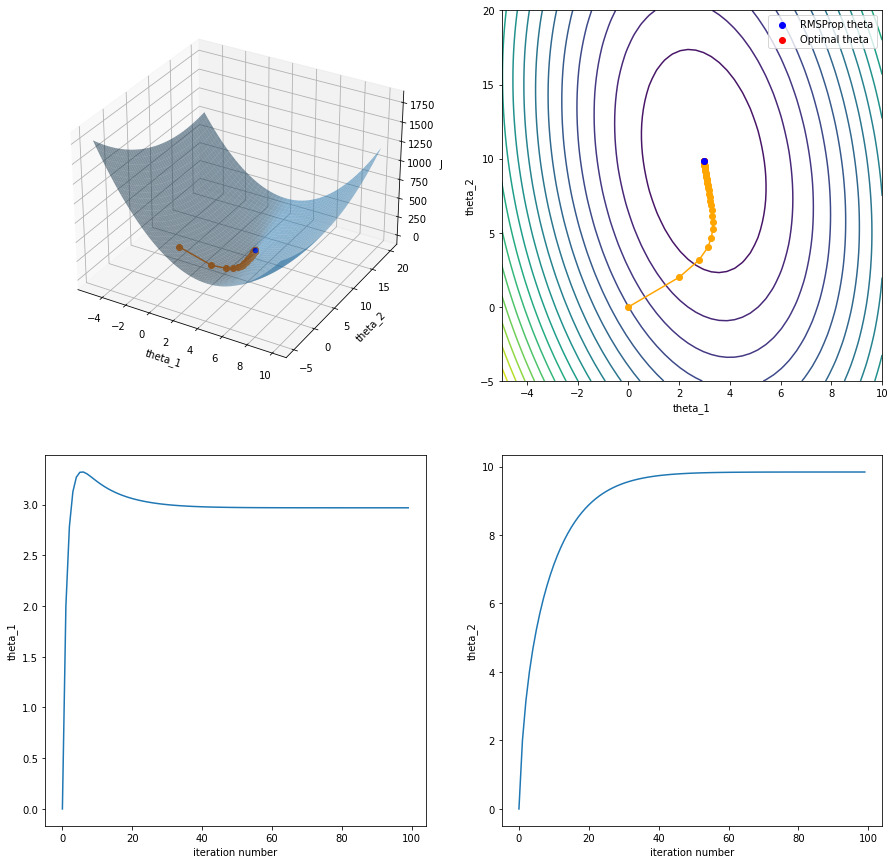

In [13]:
thetas_hist, costs = RMSProp(x_points, y_points, fit_intercept=False, lr=0.2, beta=0.99, epochs=100)
thetas_hist = np.asarray(thetas_hist).reshape((-1, 2))
print("RMSProp theta 1: ", thetas_hist[-1][0])
print("RMSProp theta 2: ", thetas_hist[-1][1])
    
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222)
visualize_cost(ax1, ax2, -5, 10, -5, 20, x_points, y_points, thetas_hist, costs, optimal_theta, 'RMSProp', ['theta_1', 'theta_2'])

ax3 = fig.add_subplot(223)
ax3.set_xlabel('iteration number')
ax3.set_ylabel('theta_1')
ax3.plot(range(thetas_hist.shape[0]), thetas_hist[:, 0])


ax4 = fig.add_subplot(224)
ax4.set_xlabel('iteration number')
ax4.set_ylabel('theta_2')
ax4.plot(range(thetas_hist.shape[0]), thetas_hist[:, 1])
plt.show()

### Mini-batch RMSProp:

In [14]:
def MiniBatchRMSProp(X, y, fit_intercept=True, lr=0.001, beta=0.99, epochs=10, batch_size = 64, shuffle=True):
    m, n = X.shape
    
    if fit_intercept:
        X = np.hstack([np.ones((m, 1)), X])
        n += 1
        
    if shuffle:
        idx = np.arange(m)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]
        
    n_batches = m // batch_size
    eps = 1e-13
    thetas = np.zeros((n, 1))
    s = 0
    thetas_hist = []
    costs = []
    
    for i in range(epochs):
        for b in range(n_batches):
            thetas_hist.append(thetas)
            X_batch = X[b * batch_size: (b+1) * batch_size]
            y_batch = y[b * batch_size: (b+1) * batch_size]
            y_predicted = X_batch @ thetas
            e_batch = y_predicted - y_batch
            cost = 1/(2*batch_size) * e_batch.T @ e_batch
            costs.append(cost.item())
            grad = 1/batch_size * X_batch.T @ e_batch
            s = beta * s + (1-beta) * np.power(grad, 2)
            thetas = thetas - lr / (np.sqrt(s) + eps) * grad
    return thetas_hist, costs

Mini-Batch RMSProp theta 1:  2.9285728773639925
Mini-Batch RMSProp theta 2:  9.873796488795746


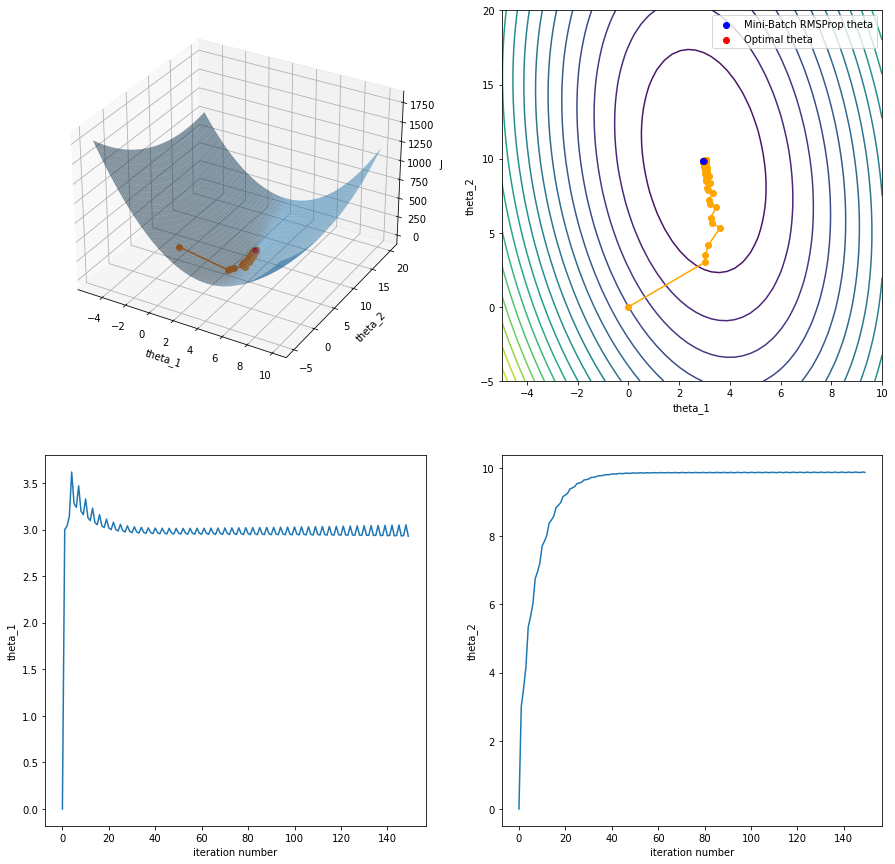

In [15]:
thetas_hist, costs = MiniBatchRMSProp(x_points, y_points, fit_intercept=False, lr=0.3, beta=0.99, epochs=50, batch_size=32, shuffle=True)
thetas_hist = np.asarray(thetas_hist).reshape((-1, 2))
print("Mini-Batch RMSProp theta 1: ", thetas_hist[-1][0])
print("Mini-Batch RMSProp theta 2: ", thetas_hist[-1][1])
    
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222)
visualize_cost(ax1, ax2, -5, 10, -5, 20, x_points, y_points, thetas_hist, costs
               , optimal_theta, 'Mini-Batch RMSProp', ['theta_1', 'theta_2'], stochastic=True)


ax3 = fig.add_subplot(223)
ax3.set_xlabel('iteration number')
ax3.set_ylabel('theta_1')
ax3.plot(range(thetas_hist.shape[0]), thetas_hist[:, 0])


ax4 = fig.add_subplot(224)
ax4.set_xlabel('iteration number')
ax4.set_ylabel('theta_2')
ax4.plot(range(thetas_hist.shape[0]), thetas_hist[:, 1])
plt.show()

## `3)` ADAM:

ADAM algorithm combines both the momentum and the adaptive learning rate and it solves both the problems of the vanishing gradient and the sparse data vecotrs.

$$Input: X$$
$$Parameters: \theta$$  
$$Hypothesis: h_{\theta}(X) = X \theta$$  
$$Cost function: J(\theta) = \frac{1}{2m}(h_\theta(x^{(i)}) - y^{(i)})^T (h_\theta(x^{(i)}) - y^{(i)})$$  
$$Gradient: \nabla_\theta J(\theta) = \frac{1}{m} X^T (h_\theta(x^{(i)}) - y^{(i)})$$
$$Goal: \theta^* = min_\theta  J(\theta) $$  
$$Update\space step: v_t = \beta_1 v_{t-1} + (1-\beta_1) \nabla J(\theta)$$
$$s_t = \beta_2 s_{t-1} + (1-\beta_2)(\nabla J(\theta))^2$$
$$\hat v_t = \frac{v_t}{1 - \beta_1 ^ t}$$
$$\hat s_t = \frac{s_t}{1 - \beta_2 ^ t}$$
$$\theta_{t+1} = \theta_t - \frac{\alpha}{\sqrt{\hat s_t} + \epsilon}*\hat v_t$$

In [16]:
def ADAM(X, y, fit_intercept=True, lr=0.7, beta_1=0.9, beta_2=0.99, epochs=100):
    m, n = X.shape
    
    if fit_intercept:
        X = np.hstack([np.ones((m, 1)), X])
        n += 1
        
    eps = 1e-13
    v = 0
    s = 0
    thetas = np.zeros((n, 1))
    thetas_hist = []
    costs = []
    
    for i in range(epochs):
        thetas_hist.append(thetas)
        y_predicted = X @ thetas
        e = y_predicted - y
        cost = 1/(2*m) * e.T @ e
        costs.append(cost.item())
        grad = 1/m * X.T @ e
        
        v = beta_1 * v + (1-beta_1) * grad
        v_corrected = v / (1 - beta_1 ** (i+1))
        s = beta_2 * s + (1-beta_2) * np.power(grad, 2)
        s_corrected = s / (1 - beta_2 ** (i+1))
        thetas = thetas - lr / (np.sqrt(s_corrected) + eps) * v_corrected
    
    return thetas_hist, costs

ADAM will suffer from some U-Turns (oscillations) because of the momentum term

ADAM theta 1:  2.9178345654891285
ADAM theta 2:  9.86340105631394


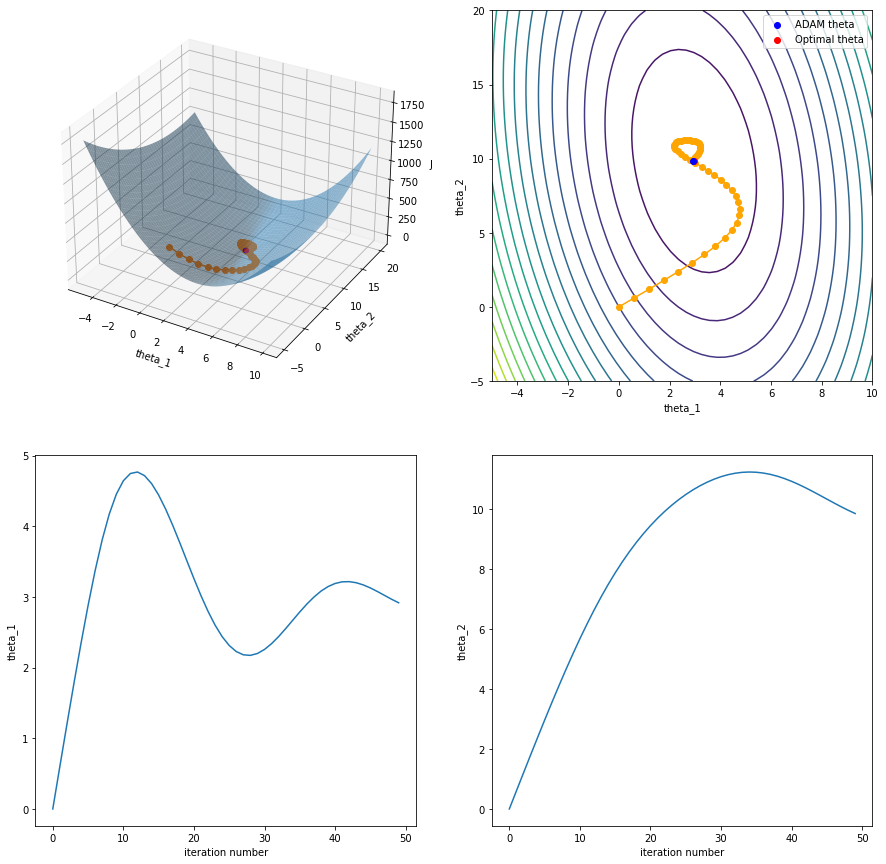

In [17]:
thetas_hist, costs = ADAM(x_points, y_points, fit_intercept=False, lr=0.6, beta_1=0.9, beta_2=0.99, epochs=50)
thetas_hist = np.asarray(thetas_hist).reshape((-1, 2))
print("ADAM theta 1: ", thetas_hist[-1][0])
print("ADAM theta 2: ", thetas_hist[-1][1])
    
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222)
visualize_cost(ax1, ax2, -5, 10, -5, 20, x_points, y_points, thetas_hist, costs, optimal_theta, 'ADAM', ['theta_1', 'theta_2'])

ax3 = fig.add_subplot(223)
ax3.set_xlabel('iteration number')
ax3.set_ylabel('theta_1')
ax3.plot(range(thetas_hist.shape[0]), thetas_hist[:, 0])


ax4 = fig.add_subplot(224)
ax4.set_xlabel('iteration number')
ax4.set_ylabel('theta_2')
ax4.plot(range(thetas_hist.shape[0]), thetas_hist[:, 1])
plt.show()

### Mini-batch ADAM:

In [18]:
def MiniBatchADAM(X, y, fit_intercept=True, lr=0.7, beta_1=0.9, beta_2=0.99, batch_size=32, epochs=10, shuffle=True):
    m, n = X.shape
    
    if fit_intercept:
        X = np.hstack([np.ones((m, 1)), X])
        n += 1
        
    if shuffle:
        idx = np.arange(m)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]
 
    eps = 1e-13
    n_batches = m // batch_size       
    thetas = np.zeros((n, 1))
    v = 0
    s = 0
    thetas_hist = []
    costs = []
    
    for i in range(epochs):
        for b in range(n_batches):
            thetas_hist.append(thetas)
            
            X_batch = X[b * batch_size: (b+1) * batch_size]
            y_batch = y[b * batch_size: (b+1) * batch_size]
            
            y_predicted_batch = X_batch @ thetas
            e_batch = y_predicted_batch - y_batch
            cost_batch = 1/(2*batch_size) * e_batch.T @ e_batch
            costs.append(cost_batch.item())
            
            grad = (1/batch_size) * X_batch.T @ e_batch
            v = beta_1 * v + (1-beta_1) * grad
            v_corrected = v / (1 - beta_1 ** (i+1))
            s = beta_2 * s + (1-beta_2) * np.power(grad, 2)
            s_corrected = s / (1 - beta_2 ** (i+1))
            thetas = thetas - lr / (np.sqrt(s_corrected) + eps) * v_corrected
            
    return thetas_hist, costs
    

Mini-Batch ADAM theta 1:  2.8841401168794114
Mini-Batch ADAM theta 2:  9.79457549531447


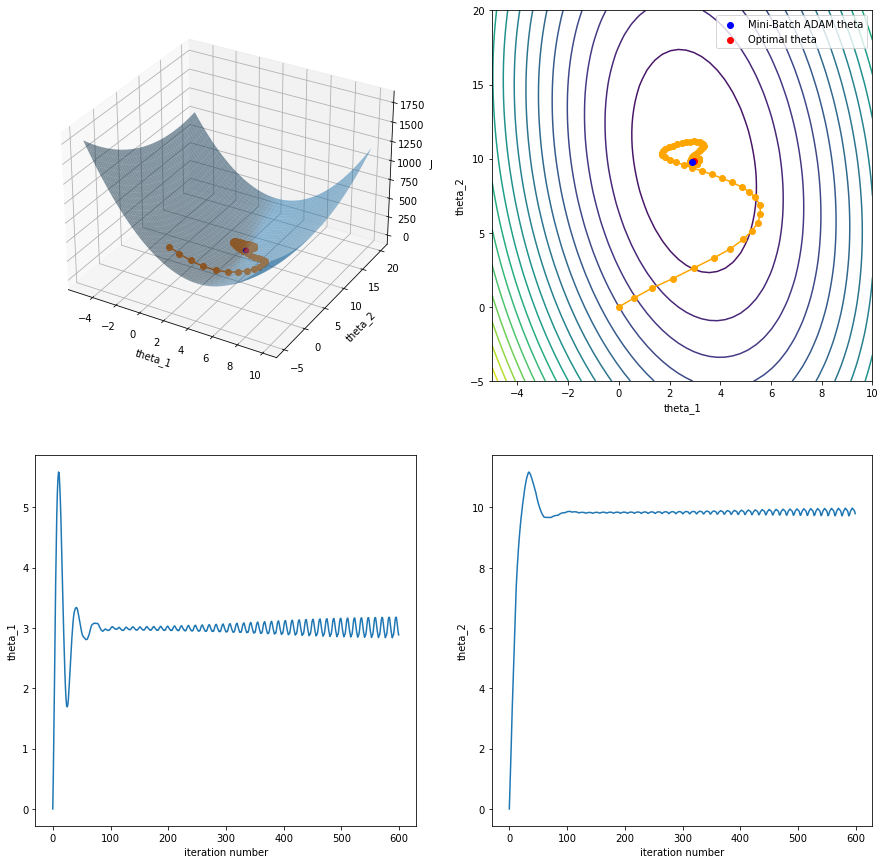

In [19]:
thetas_hist, costs = MiniBatchADAM(x_points, y_points, fit_intercept=False, lr=0.6, beta_1=0.9, beta_2=0.99, epochs=50, batch_size=8, shuffle=True)
thetas_hist = np.asarray(thetas_hist).reshape((-1, 2))
print("Mini-Batch ADAM theta 1: ", thetas_hist[-1][0])
print("Mini-Batch ADAM theta 2: ", thetas_hist[-1][1])

fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222)
visualize_cost(ax1, ax2, -5, 10, -5, 20, x_points, y_points, thetas_hist, costs,
               optimal_theta, 'Mini-Batch ADAM', ['theta_1', 'theta_2'], stochastic=True)


ax3 = fig.add_subplot(223)
ax3.set_xlabel('iteration number')
ax3.set_ylabel('theta_1')
ax3.plot(range(thetas_hist.shape[0]), thetas_hist[:, 0])


ax4 = fig.add_subplot(224)
ax4.set_xlabel('iteration number')
ax4.set_ylabel('theta_2')
ax4.plot(range(thetas_hist.shape[0]), thetas_hist[:, 1])
plt.show()